## Training an LFADS model on a 2D linear dynamical system 

- This notebook contains code to train a vanilla RNN with linear dynamics on samples from a linear dynamical system
- It illustrates how to use different components of the library like the vae module or the dataloader|

### Loading the necessary libraries

In [29]:
import os
import jax
import jax.numpy as jnp
import optax
from ilqr_vae_jax import dynamics, vae, prior, encoder, likelihood, typs, coupler, defaults
from ilqr_vae_jax.typs import *
import numpy as np
from matplotlib import pyplot as plt


## Define the parameters of the ground truth system and of the model

In [30]:
##ground true parameters 
dt = 0.05
true_n = 2 #dimensionality of the ground truth system
true_a = np.asarray([[1-0.2*dt,-2*dt], [2*dt, 1-0.2*dt]]) #defining ground-truth linear dynamics, with a rotatonal mode and a very slow decay 
true_a_eig, _ = np.linalg.eig(true_a) 
n_out = 10
true_c = jax.random.normal(jax.random.PRNGKey(0), shape = (n_out, true_n))

## dataset parameters
T = 100 # trial size
dt = 0.05 

## model parameters
n = 32
m = 2 
n_encoder = 128
m_encoder = 128
m_controller = 128 #in this case we are going to use an LFADS model with a controller

# training /savingparameters
batch_size = 32
num_train_trials = 128

dir_name = "tmp_results"
os.makedirs(dir_name, exist_ok=True)

## Generate the data

- We generate data from the ground truth system by sampling sparse inputs, and driving the linear dynamics with those. We also include a small amount of observation noise, and z-score the data to facilitate training.

In [31]:
def generate_traj(key):
    key, subkey = jax.random.split(key)
    subkey, subsubkey = jax.random.split(subkey)
    x0 = 0.05*jax.random.normal(key,shape= (true_n,))
    us = jnp.concatenate([jnp.zeros(40), jnp.ones(1), jnp.zeros(T - 41)])[...,None]
    u_idx = jax.random.normal(key = subsubkey, shape = (1,true_n))
    us = us*u_idx
    us = jnp.array(us)
    def dynamics(x, u):
        nx = true_a@x + u*dt
        return nx, nx
    x0, xs = jax.lax.scan(dynamics, x0, us)
    y = (xs@true_c.T) 
    noise = 0.001*jax.random.normal(key, shape = (T,n_out))
    y += noise
    return (y, us)

def sample_train_data(key, batch_size):
    keys = jax.random.split(key, batch_size)
    y, us = jax.vmap(generate_traj)(keys)
    std_y = jnp.std(y.reshape(-1, y.shape[-1]), axis = 0)
    mean_y = jnp.mean(y.reshape(-1, y.shape[-1]), axis = 0)
    y = (y - mean_y)/std_y
    return jnp.concatenate([jnp.arange(T)[None,...] for _ in range(batch_size)], axis = 0), us, y 


train_data = sample_train_data(jax.random.PRNGKey(122), batch_size = num_train_trials)
train_data = (train_data[0], train_data[1], (train_data[-1] - np.mean(train_data[-1].reshape(-1, train_data[-1].shape[-1])))/np.std(train_data[-1].reshape(-1, train_data[-1].shape[-1])))

## this is an example custom dataloader. It is possible to modify it or add functions, but the save_test_data and sample_test_data are required in the vae module
class Dataloader():
    def __init__(self, data, batch_size):
        self.Ts = data[0]
        self.ext_us = data[1]
        self.ys = data[2]
        self.total_samples = len(self.ys)
        self.batch_size = batch_size
        self.key = jax.random.PRNGKey(0)
        
    def save_test_data(self, saving_dir):
        _, _, os = self.sample_test_data()
        np.save(f"{saving_dir}/os.npy", os)
    
    def sample_test_data(self):
        key = jax.random.PRNGKey(0)
        _, us, os = sample_train_data(key, batch_size = 64)
        return jnp.concatenate([jnp.arange(T)[None,...] for _ in range(64)], axis = 0), us, os
    
    def __len__(self):
            return (self.total_samples + self.batch_size - 1) // self.batch_size
    def __iter__(self):
        key, subkey = jax.random.split(self.key)
        self.key = subkey
        idces = jax.random.permutation(self.key, jnp.arange(self.total_samples))
        self.ys = self.ys[idces]
        self.ext_us = self.ext_us[idces]
        for i in range(len(self)):
            start = i * self.batch_size
            end = min(start + self.batch_size, self.total_samples)
            y, ext_us = self.ys[start:end], self.ext_us[start:end]
            yield self.Ts[start:end], ext_us, y, jnp.arange(start, end)
            
train_dataloader = Dataloader(train_data, batch_size)

### Plot the data

Text(0, 0.5, 'Observations')

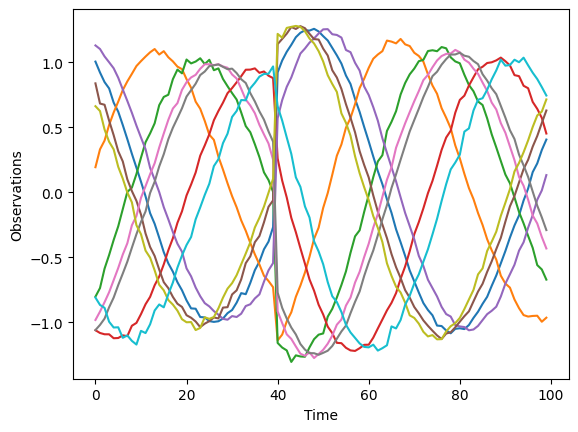

In [32]:
ys = train_data[-1]
plt.plot(ys[0])
plt.xlabel('Time')
plt.ylabel('Observations')

## Fit the model
- Below is example code to train the model
- We can choose either a "student" or a "gaussian" prior. It will be a lot more challenging to recover sparse posterior inputs from the Gaussian prior, while the LFADS model can accurately recover the sparse inputs with the heavy-tailed Student prior (try it for yourself! the difference should be very clear.)
- we define each of the components of the VAE (dynamics, prior, likelihood, encoder/controller) and pass them to initialize the VAE class.
- We also define some of the training hyperparameters.

In [47]:
prior_choice = 'student' #gaussian or student

optimizer = optax.adam
regularizer_function = lambda prms : 0.001*jnp.linalg.norm(prms.dyn_params.a)**2
dims = typs.Dims(n_out = n_out, n = n, m = m, m_encoder = m_encoder, n_encoder = n_encoder, m_controller = m_controller, n_controller = 64, horizon = T)
dyn_module = dynamics.VRNN(phi = lambda x : x, dims = dims)
prior_module = prior.Student(dims = dims) if prior_choice == 'student' else prior.Gaussian(dims = dims)
likelihood_module = likelihood.Gaussian(dims = dims)
encoder_module = encoder.BiRNN(dims = dims)
coupler_module = coupler.GRUController(dims =dims)
lr_scheduler = optax.exponential_decay(0.01, transition_steps = 1, decay_rate = 0.999)
training_hparams = defaults.default_training_hparams
training_hparams = training_hparams._replace(total_num_datapoints = num_train_trials, num_epochs = 200, batch_size = batch_size, lr_scheduler = lr_scheduler, optimizer = optimizer, regularizer = regularizer_function)
vae_module = vae.VAE(dynamics = dyn_module, prior = prior_module, likelihood = likelihood_module, coupler = coupler_module, encoder = encoder_module, dataloader = train_dataloader, training_hparams = training_hparams, dims = dims, inputs_allowed=1, saving_dir = dir_name)


vae_module.train()

epoch 0 | time = 12.811199188232422| loss: 1.442368539290916 ~ ll: -14275.554011775017. entropy: 209.84759372346454. log_prior: -4529.965951938407
epoch 1 | time = 20.210111141204834| loss: 1.2338568858963261 ~ ll: -11578.555509957834. entropy: -137.243945121233. log_prior: -4709.47315868481
epoch 2 | time = 24.817190170288086| loss: 1.1761761693438653 ~ ll: -10438.740732138223. entropy: -15.991094943232923. log_prior: -4612.617745402167
epoch 3 | time = 28.786089181900024| loss: 1.119282119783498 ~ ll: -9455.339740824751. entropy: 349.05112390035464. log_prior: -4515.042578520846
epoch 4 | time = 32.48170018196106| loss: 1.166630452535732 ~ ll: -9598.225712611113. entropy: 613.9189065215089. log_prior: -4391.378769688685
epoch 5 | time = 36.741055965423584| loss: 1.16861859160274 ~ ll: -9284.393325627349. entropy: 797.4854014334651. log_prior: -4344.780918993109
epoch 6 | time = 39.865907192230225| loss: 1.1561815654534917 ~ ll: -8880.4906370654. entropy: 998.0501833374688. log_prior:

## Plot of the loss
- We can use this plot of the negative ELBO (+ regularizer term if any) to verify that the training has gone smoothly. If we see peaks or instabilities, this suggests potentially having to decrease the learning rate.

Text(0, 0.5, 'Loss')

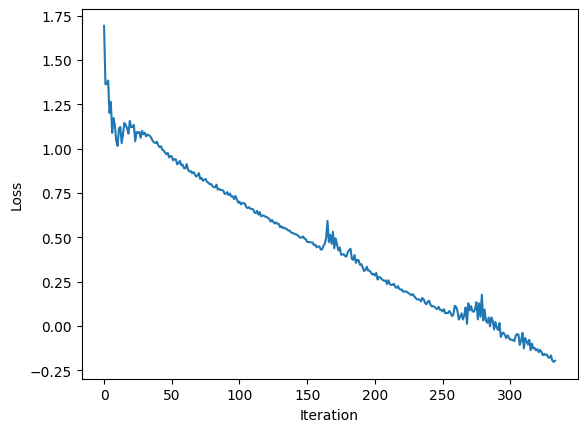

In [43]:
loss = vae_module.losses
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')

## Plot the model predictions / inputs (on test data)

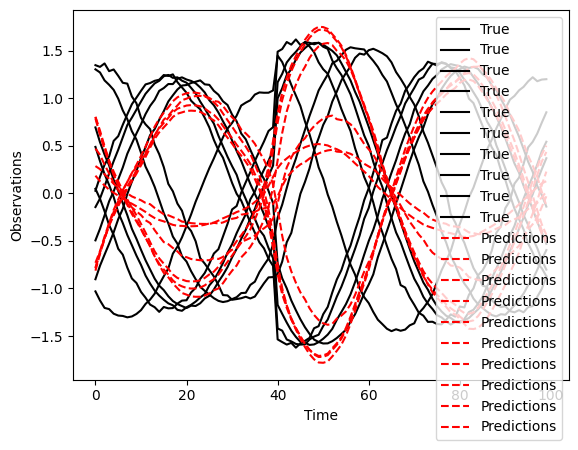

In [44]:

predictions = np.load(f"{dir_name}/predictions.npy")
ys = np.load(f"{dir_name}/os.npy")
plt.plot(ys[0], "k", label = "True")
plt.plot(predictions[0], "--r", label = "Predictions")
plt.xlabel("Time")
plt.ylabel("Observations")
plt.legend()



Text(0, 0.5, 'Inputs')

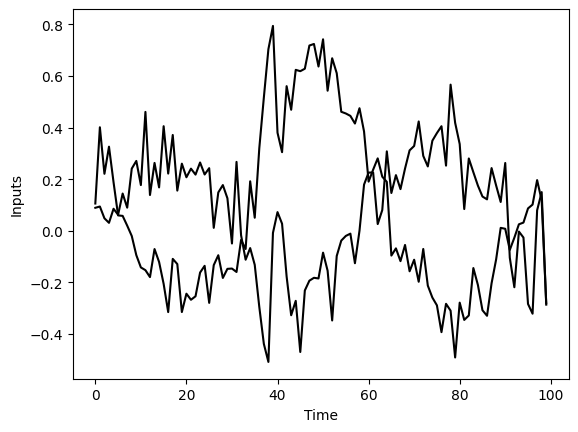

In [45]:
us = np.load(f"{dir_name}/inputs.npy")
plt.plot(us[0], "k", label = "True")
plt.xlabel("Time")
plt.ylabel("Inputs")

## Comparison of the learned / true dynamics
- In a linear system like this, we can direclty evaluate how well we have recovered the dynamics of the system by looking at the eigenvalues.
We see that the LFADS model recovers the eigenvalue pair corresponding to the ground truth rotation. 
- Interestingly, the model also learns spurious eigenvalues. One way to decrease the strength of those is to increase the regularization of the A matrix norm -- this is something you can play with ! 

Text(0, 0.5, 'Imaginary')

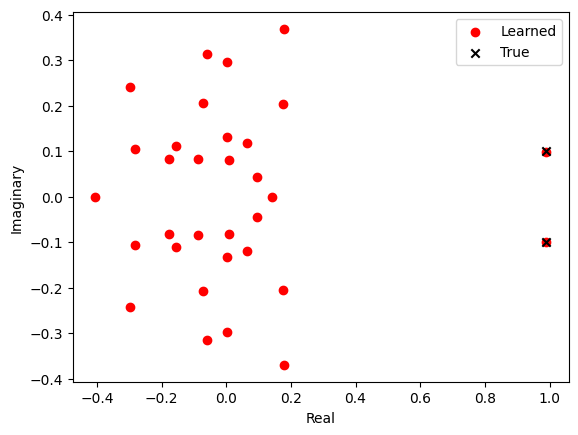

In [46]:
true_a_eig = np.linalg.eig(true_a)[0]
learned_a_eig = np.linalg.eig(vae_module.params.dyn_params.a)[0]
plt.figure()
plt.scatter(learned_a_eig.real, learned_a_eig.imag, color = "r", label = "Learned")
plt.scatter(true_a_eig.real, true_a_eig.imag, color = "k", marker = "x", label = "True")
plt.legend()
plt.xlabel("Real")
plt.ylabel("Imaginary")


Here, we see that the model is able to accurately recover the eigenvalues, even though it struggles to perfectly 
It will be more challenging to recover the dynamics if we eg decrease the signal to noise ratio or the number of datapoints -- this is something you can play with!